# Exposure to drought


A simple accepted measure for drought is the Standardized Precipitation Index (SPI). Similar to indicators 1.1 and 1.2, this indicator is not a direct measure of health impacts of drought, but rather a measure of the risk factor, which is mediated by a range of complicated causes to health. In general, the claim is that increase in this indicator represents an increased risk, which may lead directly to negative impacts on health or require adaptation measures to mitigate negative impacts.



| SPI  A+S   | SPI Agnew| Category         |
|------------|----------|------------------|
|  >-0.99    | >= -0.84 | Normal           | 
| -1.5 to -1 | < -0.84  | Moderate Drought |
| -1.5 to -2 | < -1.28  | Severe drought   | 
| < -2       | < -1.65  | Extreme drought  |



Select the locations experiencing 'Severe' drought. Define the drought indicator as 'number of months in drought' for a given year.

> NOTE use the -1.5 threshold since it was defined by WMO 2012 document


## Literature on selection of drought index

In 2009, the World Meteorological Organization (WMO) approved the Lincoln Declaration on Drought Indices (LDDI). The LDDI recommends that "the Standardized Precipitation Index (SPI) be used to characterize the meteorological droughts around the world", in addition to other drought indices that were in use in their service. In support of this recommendation, it was suggested that a "comprehensive user manual" describing the SPI should be developed. The manual provides a description of the index, the computation methods, specific examples of where it is currently being used, the strengths and limitations and mapping capabilities.

https://www.ncl.ucar.edu/Applications/spi.shtml

https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi


Note this one also good for extreme rain

https://link.springer.com/chapter/10.1007/978-94-015-9265-9_2

## SPI drought index

> IMPORTANT: indication from publication (see other doc) that SPI and SPEI diverge due to temperatures. Looking at results the divergance is significant globally! This has implications on both the Lancet results directly and more generally on the use of SPI vs SPEI as an indicator of global prevalence of drought


Python code:

https://www.drought.gov/drought/python-climate-indices


## Data for SPI

Monthly summary data for PPT from ERA interim

Use PPT data from CRU https://crudata.uea.ac.uk/cru/data/hrg/ http://data.ceda.ac.uk//badc/cru/data/cru_ts/cru_ts_4.01/data/ which covers a much longer time period than ECMFW ERA Interim (but only at monthly scale, which is not enough for heatwaves and i think labour).


## Weighting indicator by population and by area

Initial calculation just did a drought count, but this ignores the relative size of the grid squares. A better approach could be to follow https://www.nature.com/articles/s41598-017-14283-2 with 'area in drought' (would need to calculate the real rather than relative size of grid squares).

The question is then how to calculate the population impacted? One possibility is to simply calculate the number of people. This would NOT be directly comparable to the area in drought however. It would only be able to show the relative trends.


In [3]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt


from cartopy import crs

from scipy import stats
from tqdm import tnrange, tqdm_notebook


import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC


In [19]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

# For CRU data we only go to 2016 for now. Address this in future versions...
MAX_YEAR = 2016

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

RESULTS_FOLDER = Path('./results/lancet2018/global/1.4 drought')

EXTREME_DROUGHT_THRESHOLD = -1.5

SPI_PROJ_OUT = DATA_SRC / 'lancet' / 'spi6_projected'
SPI_PROJ_OUT.mkdir(exist_ok=True)

In [3]:
# from dask.distributed import Client
# client = Client()
# client

In [21]:
spi6 = xr.open_dataarray(WEATHER_SRC / 'cru' / 'spi6_1901_2016_cru.nc',
                         chunks={'time': 12}
                        )

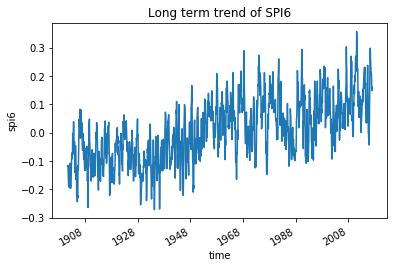

In [5]:
spi6.mean(dim=['lon','lat'], skipna=True).plot()
plt.title('Long term trend of SPI6')
plt.savefig(RESULTS_FOLDER / 'spi6_longterm.png', dpi=300)

In [22]:
spi_sel = spi6.sel(time=slice('2000-01-01',None,None))

In [11]:
pop = population_tools.load_masked_population()
res = []
current_year = spi_sel['time.year'][0]

for time in tqdm_notebook(spi_sel.time):
    year = time.dt.year.values
    if year != current_year:
        res = xr.concat(res, spi_sel.time.loc[f'{year}-01-01':f'{year}-12-31'])
        res = res.to_dataset(name='spi')
        res.to_netcdf(SPI_PROJ_OUT / f'spi6_{year}.nc')
        res = []
        current_year = year
    
    data_slice = spi6.sel(time=time).squeeze().load()
    pop_slice = pop.population.sel(year=year).squeeze(drop=True).load().drop('year')
    proj = population_tools.project_param(pop_slice, data_slice)
    res.append(proj * pop_slice)
    

In [4]:
spi6_proj = xr.open_mfdataset(str(SPI_PROJ_OUT / 'spi6_*.nc'), 
                              drop_variables=['year']
                             )

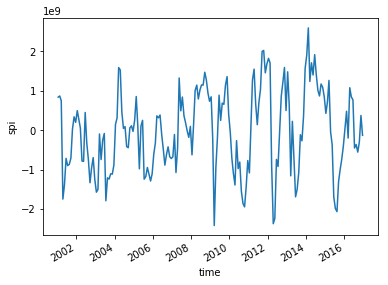

In [5]:
spi6_proj_ts = spi6_proj.spi.sum(dim=['longitude','latitude'], skipna=True)

spi6_proj_ts.plot()


## Calculate the number of months where the SPI dropped below the threshold for drought and plot

- Consider the incidences of 'Moderate' drought (SPI< -1)
- Consider the incidences of 'Severe' drought (SPI< -1.5)


In [23]:
droughts = spi6.where(spi6 < EXTREME_DROUGHT_THRESHOLD)

event_counts = droughts.groupby('time.year').count(dim='time').astype(np.float32)

## Map the mean drought counts per year

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in less
  return func(*args2)


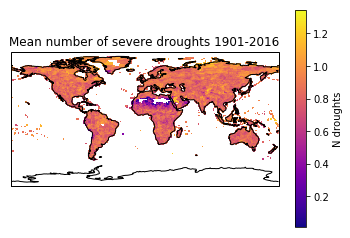

In [8]:
event_counts_mean = event_counts.mean(dim='year')
event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N droughts'
# drought_counts_mean.plot()

f = plt.figure()
ax = plt.subplot(projection=crs.PlateCarree())
p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title(f'Mean number of severe droughts 1901-{MAX_YEAR}')

plt.savefig(RESULTS_FOLDER / f'mean n droughts 1901-{MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=300)

## Express global trend as 'area in drought'

In [9]:
# Calculate grid cell areas
delta_lon = spi6.lon[1] - spi6.lon[0]
earth_radius = 6371

areas = (np.sin(np.radians(spi6.lat.values + 0.25))
 - np.sin(np.radians(spi6.lat.values - 0.25))) * (np.radians(delta_lon.values)) * earth_radius**2

In [10]:
in_drought = spi6 < EXTREME_DROUGHT_THRESHOLD
in_drought = in_drought.astype(int)

in_drought['areas'] = xr.DataArray(areas, dims=['lat'], coords={'lat': in_drought.lat})
in_drought = in_drought * in_drought.areas

In [11]:
drought_area_ts = in_drought.sum(dim=['lat', 'lon']).compute()
drought_area_ts.name = 'million km2'

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [12]:
drought_area_ts.to_dataframe().to_excel(RESULTS_FOLDER / 'area_in_drought_spi6.xlsx')

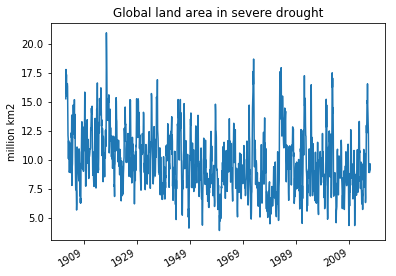

In [13]:
(drought_area_ts[12:] / 1_000_000).plot()
plt.title('Global land area in severe drought')
plt.xlabel('')
plt.savefig(RESULTS_FOLDER / 'area_in_drought_spi6.png', dpi=300)

In [14]:
drought_ref = (in_drought
               .sel(time=slice(f'{REFERENCE_YEAR_START}-01-01', f'{REFERENCE_YEAR_END}-12-31'))
               .groupby('time.month')
               .mean(dim='time'))

In [15]:
in_drought.sel(time=slice(f'{REFERENCE_YEAR_START}-01-01', f'{REFERENCE_YEAR_END}-12-31'))

<xarray.DataArray (lat: 360, lon: 720, time: 240)>
dask.array<shape=(360, 720, 240), dtype=float64, chunksize=(360, 720, 12)>
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 -178.25 -177.75 -177.25 ...
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * time     (time) datetime64[ns] 1986-01-16 1986-02-15 1986-03-16 ...
    areas    (lat) float64 13.49 40.45 67.43 94.39 121.4 148.3 175.2 202.2 ...

## Project the drought counts to the population to get the drought exposure

In [16]:
# Convert the drought data from -180 to 180 => 0 to 360
event_counts = event_counts.roll(lon=len(event_counts.lon)//2)

lons = event_counts['lon'].values
lons[lons <0 ] += 360
event_counts['lon'] = lons

In [ ]:
event_counts

In [17]:
drought_count_projected = population_tools.project_to_population(event_counts, 
                                                                 end_year=2016, 
                                                                 norm=False, get_ts=False)

In [18]:
event_count_projected_ts = drought_count_projected.sum(dim=['latitude', 'longitude']).compute()

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [15]:
event_count_projected_ts = event_count_projected_ts.to_dataframe('drought exposures')

event_count_projected_ts.to_excel(RESULTS_FOLDER / 'drought exposures.xlsx')

In [16]:
event_count_projected_ts = pd.read_excel(RESULTS_FOLDER / 'drought exposures.xlsx').set_index('year')

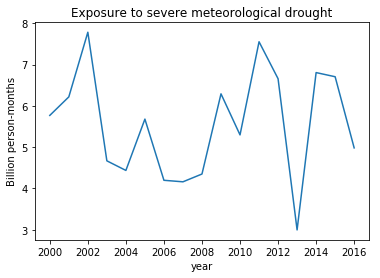

In [18]:
(event_count_projected_ts['drought exposures'] / 1_000_000_000).plot()
plt.ylabel('Billion person-months')
plt.title('Exposure to severe meteorological drought')
plt.savefig(RESULTS_FOLDER / 'drought exposure.png', dpi=300)
plt.savefig(RESULTS_FOLDER / 'drought exposure.pdf')

In [21]:
event_count_projected_ts.mean() / 1_000_000_000

<xarray.DataArray ()>
array(5.563077)

# Calculate the change in N events relative to baseline

In [24]:
event_counts_ref = event_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')

In [25]:
event_change = event_counts.sel(year=slice(2000, None)) - event_counts_ref

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in less
  return func(*args2)


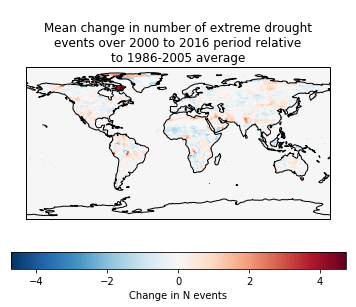

In [26]:
data = event_change.mean(dim='year')

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.PlateCarree())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N events')

ax.coastlines()

plt.title(f'''
Mean change in number of extreme drought
events over 2000 to {MAX_YEAR} period relative
to {REFERENCE_YEAR_START}-{REFERENCE_YEAR_END} average''')

plt.savefig(RESULTS_FOLDER / f'mean events change 2000-{MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=600)
plt.savefig(RESULTS_FOLDER / f'mean events change 2000-{MAX_YEAR} map.pdf', 
            bbox_inches='tight')

In [25]:
event_change_ts = event_change.sum(dim=['lat', 'lon']).compute()

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [26]:
drought_change_projected = population_tools.project_to_population(event_change, 
                                                                 end_year=2016, 
                                                                 norm=False, get_ts=True).compute()

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in less
  return func(*args2)


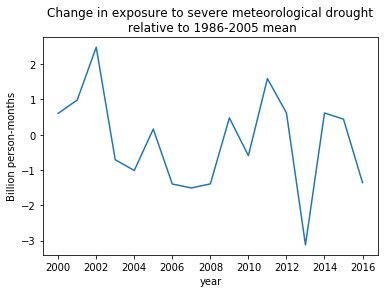

In [28]:
(drought_change_projected / 1_000_000_000).plot()
plt.ylabel('Billion person-months')
plt.title(f'Change in exposure to severe meteorological drought\n relative to {REFERENCE_YEAR_START}-{REFERENCE_YEAR_END} mean')
plt.savefig(RESULTS_FOLDER / 'drought exposure change.png', dpi=300)